# Benchmark de différent classifier 

## SVM classifier

Dans un premier temps, on va se servir d'un svm classifier et tester les performances

In [3]:
!pip install --no-cache-dir -r requirement.txt


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from skimage.feature import hog
import cv2  
import os
import pandas as pd
from sklearn.model_selection import train_test_split,cross_val_score,validation_curve,GridSearchCV,learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import skimage.io as io
from tqdm import tqdm
import numpy as np
import matplotlib as mp

IMG_PATH = "../DATA"
Data = pd.DataFrame()
UPLOAD_PATH = "Upload"
folders = os.listdir(IMG_PATH)


In [5]:
train_data = pd.DataFrame()



def load_data_images(folder_path):
    target = 0
    img_error = []
    df = pd.DataFrame()
    #crée un dictionnaire 
    img_dict = {}
    img_dict["Path"] = []
    img_dict["Target"] = []
    #for each class
    for sub_folder in tqdm(os.listdir(folder_path)):
        sub_folder_path = os.path.join(folder_path,sub_folder)
        target +=1 
        #for each image
        for filename in os.listdir(sub_folder_path):
            img_path = os.path.join(sub_folder_path, filename)
            try :
                #lecture de l'image en niveau de gris 
                img = io.imread(img_path, as_gray=True)
                #resize de l'image !Problème d'echelle
                resized_img = resize(img, (32, 32),anti_aliasing=True)  
                #Application de la fonction HOG pour extraire les features
                fd = hog(
                    resized_img,
                    orientations=8,
                    pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1)
                )
                img_dict["Path"].append(img_path)
                img_dict["Target"].append(target)
                
                #Sauvegarde dans le dictionnaire, 1 ligne = 1 image 
                for i in range(fd.shape[0]) :
                    #Si la colonne n'existe pas on la crée avant l'ajout 
                    colonne = f"FD{i}"
                    if colonne not in img_dict :
                        img_dict[colonne] = [] 
                    img_dict[colonne].append(fd[i])
                
                # print(images_list)
            except :
                img_error.append(f"{filename}, {sub_folder}")
        #passage du dictionnaire en Dataframe 
        df = pd.DataFrame(img_dict)
        
        # data = pd.concat([data,dict_df])
        # print(data)
    print("Image Error :\n" ,img_error)
    #Passage de Dataframe en CSV 
    df.to_csv("data.csv",sep=";",index=False)
        
    return df 

data = load_data_images(IMG_PATH)



  0%|          | 0/36 [00:00<?, ?it/s]c:\Users\Rafff\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 36/36 [32:54<00:00, 54.84s/it]

Image Error :
 ['Image_56.jpg, bell pepper']


In [9]:

img = io.imread("../Data/apple/Image_1.jpg", as_gray=True)
#resize de l'image !Problème d'echelle

print(img.shape)
resized_img = resize(img, (32, 32),anti_aliasing=True)  


(2216, 2218)


In [12]:
Flat_img = resized_img.flatten()
print(Flat_img[0])

1.0


In [ ]:
img = cv2.imread("../Data/apple/Image_1.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# Noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

# Sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

markers = cv2.watershed(img,markers)
img[markers == -1] = [255,0,0]

cv2.imshow('Original Image', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [2]:
def show_graph_train(conf_matrix, data, classes:int):
    """ Affiche des graphs pour chacune des metrics, un nuage de point prennant les metrics en abs et ord et
    affiche la matrice de confusion du modèle 
    """
    plt.close()
    data = pd.read_csv(data)
    labels = []
    fig ,ax = plt.subplots()

    cmap = mp.colors.LinearSegmentedColormap.from_list('',['white','black'])
    im = ax.imshow(conf_matrix,cmap = "plasma")
    # à rendre generique pitié 
    for i in range(1, classes +1 ):
        labels.append(f"{i}")
    ax.set_xticks(np.arange(classes),labels = labels )
    ax.set_yticks(np.arange(classes),labels = labels )
    ax.set_xlabel("Expected")
    ax.set_ylabel("Predicted")
    ax.set_title('Confusion matrix')
    fig.colorbar(im,orientation = 'vertical')


    plt.savefig("Graph")
    # plt.show(block = False)

def training_SVM(path : str) -> SVC:
    """Entrainement d'un modèle SVC à partir d'un ficher passer en paramètre
        et renvoie le modèle entrainée """	

    Data = pd.read_csv(path,delimiter=";")
    print(Data.shape)
    
    X = Data.iloc[:,2:].values #récupère les variables explicatives 
    Y = Data.iloc[:,1].values # récupère les variables à prédire 
    Params = [{"gamma": [0.01,0.001,0.0001], "C":[1,10,100,1000]}]
    
    print("y = ",Y)
    # Data.head() #récupère les 5 premières lignes 

    # Diviser les données afin d'obtenir un jeu de test et un jeu d'entrainement 
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2)
    print(X_train)

    #Création du Modèle SVM et entrainement 
    print("____ Création du modele ____")
    modele = SVC(kernel = 'linear', random_state = 0)
    modele.fit(X_train,Y_train)
    print("____ Modele crée et entrainé ____")

    #Première prediction sur le jeu de test 
    print("____ Début de prédiction ____")
    Y_pred = modele.predict(X_test)
    print("Prediction :\n",Y_pred)

    #Matrice de Confusion 
    print("____ matrice de confusion ____")
    conf_matrix = confusion_matrix(Y_test, Y_pred)
    print(conf_matrix)
    # show_graph_train(conf_matrix,path,36)
    
    #validation curve
    #Cross validation 
    val = cross_val_score(modele,X,Y,cv=5)
    print(val)

    N, train_score,val_score = learning_curve(SVC()
                                              ,X_train,Y_train,train_sizes= np.linspace(0.1,1.0,10), cv=5)
    
    plt.plot(N,train_score.mean(axis=1), label='train')
    plt.plot(N, val_score.mean(axis=1), label='validation')
    plt.xlabel("train_sizes")
    plt.legend()
    plt.savefig("learning_graph")
    
    grid_search = GridSearchCV(SVC(),Params,verbose=10)
    
    grid_search.fit(X_train,Y_train)
    
    best_estimator = grid_search.best_estimator_
    N, train_score,val_score = learning_curve(best_estimator
                                              ,X_train,Y_train,train_sizes= np.linspace(0.1,1.0,10), cv=5)
    
    plt.plot(N,train_score.mean(axis=1), label='train')
    plt.plot(N, val_score.mean(axis=1), label='validation')
    plt.xlabel("train_sizes")
    plt.legend()
    plt.savefig("learning_graph_grid")
    
    y_prediction = best_estimator.predict(X_test)
    conf_matrix = confusion_matrix(Y_test, y_prediction)
    print(classification_report(Y_test,Y_pred))
    show_graph_train(conf_matrix,path,36)
    
    return modele


(3114, 1026)
y =  [ 1  1  1 ... 36 36 36]
[[0.17806176 0.28223891 0.29037678 ... 0.39916395 0.41585626 0.4443472 ]
 [0.36609357 0.47977342 0.52430955 ... 0.10707926 0.10711469 0.10345954]
 [1.         1.         1.         ... 1.         1.         1.        ]
 ...
 [0.92980972 0.94077542 0.95253306 ... 0.48421989 0.58083973 0.76789897]
 [0.99607843 0.99609363 0.99659848 ... 0.99728711 0.99672655 0.99809962]
 [0.83265721 0.86967542 0.87323688 ... 0.26369665 0.26255208 0.26722117]]
____ Création du modele ____
____ Modele crée et entrainé ____
____ Début de prédiction ____
Prediction :
 [33 12 21 19  7 34  5 33 32 10  7 28 12 13 24  6 35  8 36 27 23 24 24  7
 11  7 16  7  9 28 16 15 27 23  4 16 33 23  2 35  3  7 35 10 17 34 13 15
  6 18 12 28 17 27 34  8  7  4  2 31 12  1  4  2 19 29 29 18 28 11  3 32
 16 21 14  2 29 36 34 22 17  1 20  4  1 25 14  1 34 29 29 31  9 21  2  4
 15  1  1  5 33 26  3 16  8 34 17 18 23 28 30 11 16 17  1 12 27 23 27  4
 11 31 24 27 15 27  7  5 10 34 16 23  8  5

SVC(kernel='linear', random_state=0)

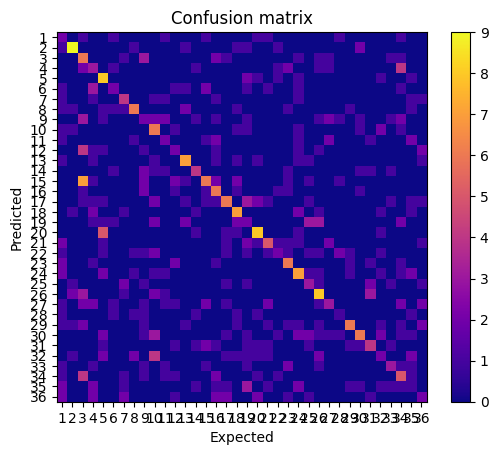

In [5]:
training_SVM("../data_pixel.csv")